# Alpha Signals: ML-Driven Stock Prediction

This notebook predicts next-day stock price movement using technical indicators and machine learning, while also performing time series diagnostics (stationarity, trend, seasonality, autocorrelation).

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


In [24]:
!pip install ta
import ta

In [25]:
from datetime import date

# Get today's date
today = date.today()

# Format the date as a string (YYYY-MM-DD)
end_date = today.strftime('%Y-%m-%d')

end_date

'2025-07-06'

## Load Stock Data

In [32]:
# pulling the reliance stock data from 2019 to present day
df = yf.download('BARC.L', start='2021-01-01',end=end_date)
df.dropna(inplace=True)

# Flatten the MultiIndex columns
df.columns = [col[0] for col in df.columns]

/tmp/ipython-input-32-2470449931.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BARC.L', start='2021-01-01',end=end_date)
[*********************100%***********************]  1 of 1 completed


In [34]:
print("DataFrame head:")
print(df.head())
print("\nDataFrame tail:")
print(df.tail())

DataFrame head:
                 Close        High         Low        Open    Volume
Date                                                                
2021-01-04  143.287674  148.818699  142.189449  146.782008  45934459
2021-01-05  142.968216  144.306043  138.690148  140.432334  36696545
2021-01-06  154.789032  155.807385  145.184609  145.763672  88207450
2021-01-07  155.867264  157.744225  150.760554  156.825716  60453467
2021-01-08  152.672424  157.943875  152.327982  157.085267  35279721

DataFrame tail:
                 Close        High         Low        Open    Volume
Date                                                                
2025-06-30  337.299988  339.399994  332.450012  338.799988  22865391
2025-07-01  329.700012  336.799988  329.450012  335.799988  24617583
2025-07-02  325.750000  338.024994  319.350006  336.049988  51318423
2025-07-03  332.350006  335.850006  325.049988  327.000000  33811657
2025-07-04  330.500000  333.450012  329.149994  330.799988  15476731


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1136 entries, 2021-01-04 to 2025-07-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1136 non-null   float64
 1   High    1136 non-null   float64
 2   Low     1136 non-null   float64
 3   Open    1136 non-null   float64
 4   Volume  1136 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.2 KB


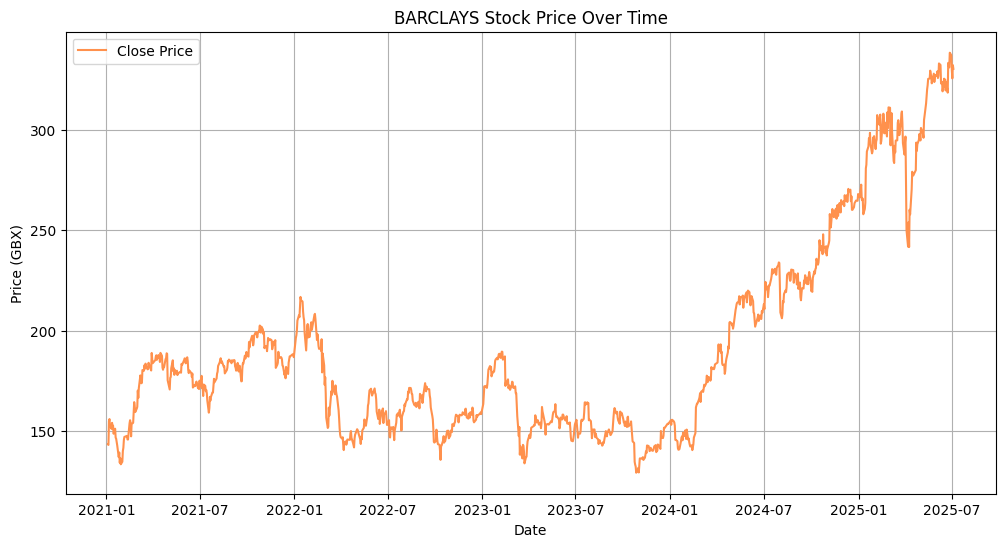

In [36]:
# Plotting the closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color = '#FF914D')
plt.title('BARCLAYS Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (GBX)')
plt.legend()
plt.grid(True)
plt.show()

## Time Series Diagnostics
We begin by checking trend, seasonality, autocorrelation, and stationarity.

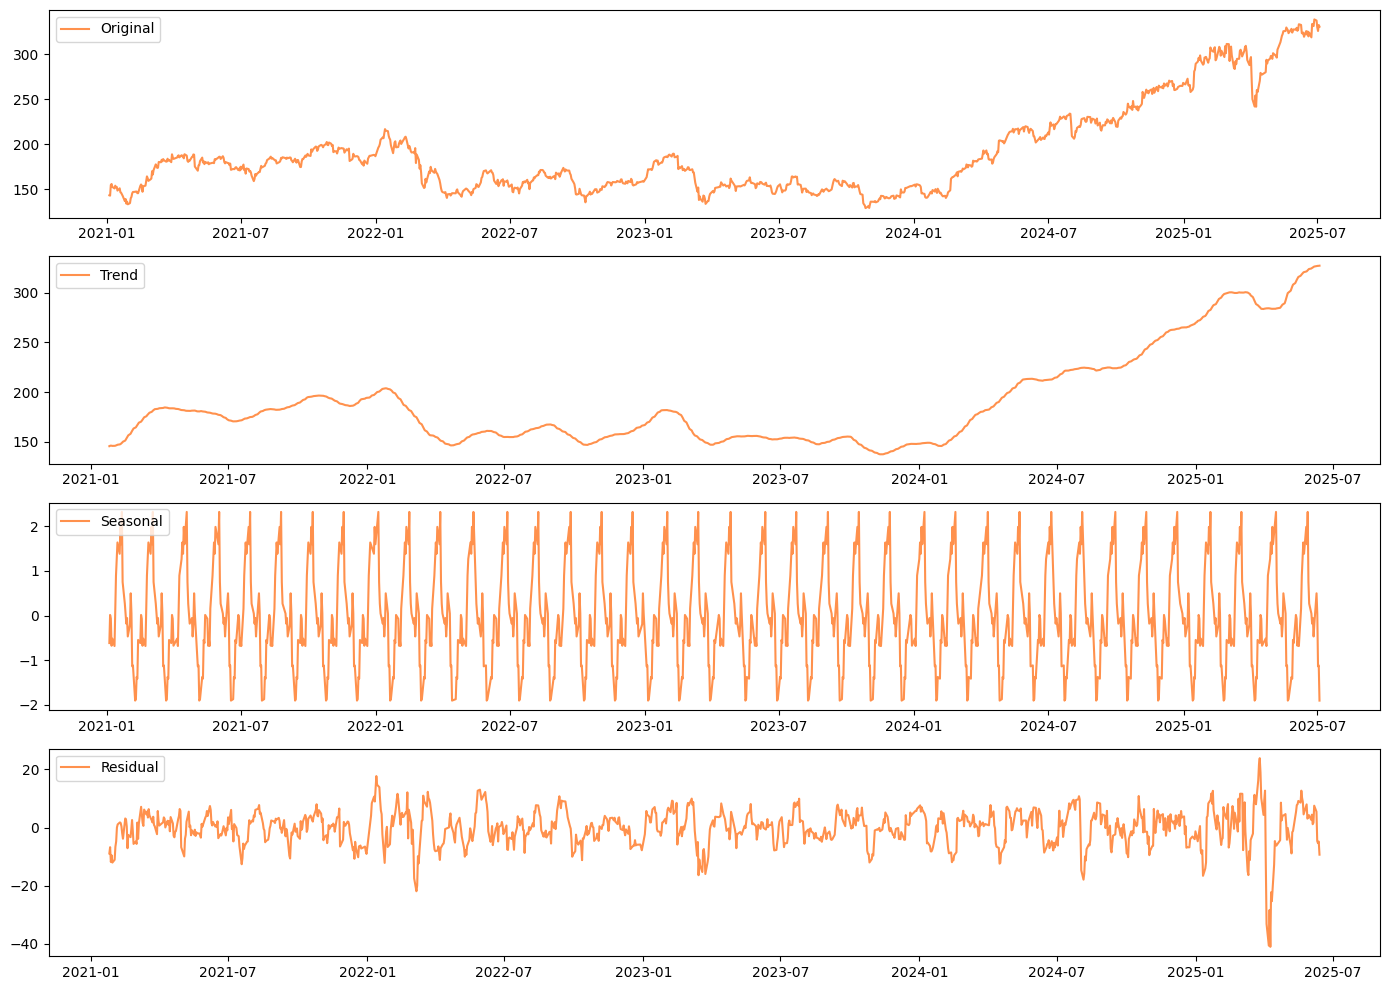

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series using additive decomposition
# for multiplicative relationship use model = "multiplicative"
# period can be changed on the observed data
decomposition_additive = seasonal_decompose(df['Close'], model='additive', period=30)
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

# Plotting the additive decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['Close'], label='Original', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color = '#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


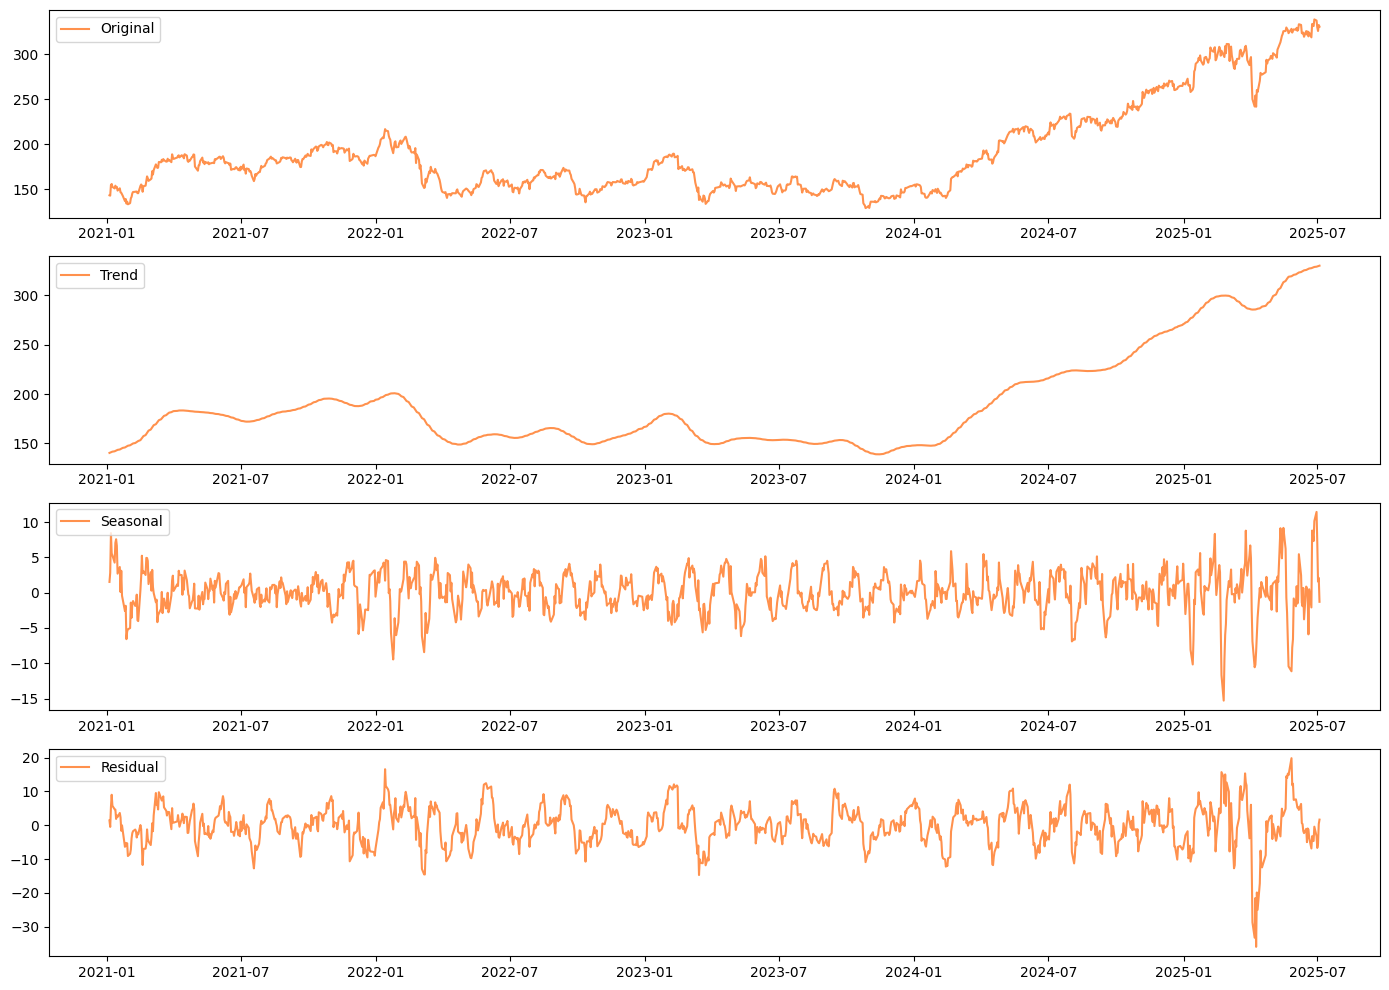

In [38]:
from statsmodels.tsa.seasonal import STL


# Perform STL decomposition
stl = STL(df['Close'], period=30)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(result.observed, label='Original', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color = '#FF914D')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual', color = '#FF914D')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


ADF Statistic: 0.16921459700978528
p-value: 0.9704811041776819
Critical Values:
   1%: -3.436
   5%: -2.864
   10%: -2.568


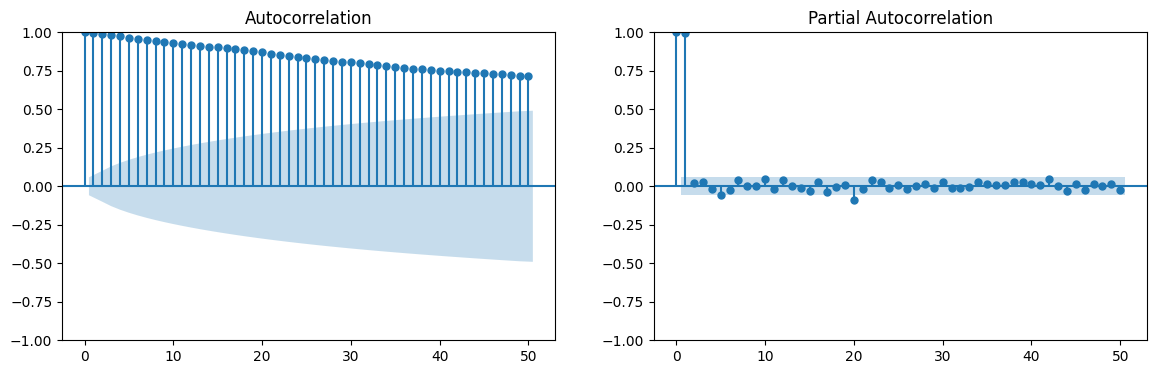

In [39]:
# ADF Test for stationarity
result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {round(value,3)}')

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(df['Close'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.show()


# output proves data is non-stationary

## Feature Engineering: Technical Indicators

In [47]:
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['Volatility'] = df['Close'].rolling(window=10).std()

df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

print("\nDataFrame head after feature engineering:")
print(df.head())
print("\nDataFrame tail after feature engineering:")
print(df.tail())


DataFrame head after feature engineering:
                 Close        High         Low        Open    Volume  \
Date                                                                   
2021-08-06  182.375397  183.114234  178.657200  179.100509  43064760   
2021-08-09  184.092697  184.532014  181.856182  182.914528  24985030   
2021-08-10  185.091156  185.510500  183.254011  184.671812  23847919   
2021-08-11  186.209396  186.908303  183.864058  185.410640  21471281   
2021-08-12  183.992615  186.089574  180.897122  184.232272  33481678   

                  RSI      MACD      SMA_20      SMA_50  Volatility  target  \
Date                                                                          
2021-08-06  64.966549  1.760894  170.951214  174.568372    4.265636       1   
2021-08-09  66.875256  2.338568  171.533306  174.593932    4.486848       1   
2021-08-10  67.967977  2.844160  172.301108  174.589938    4.288116       1   
2021-08-11  69.193683  3.297072  173.089876  174.591136  

## Modeling: Binary Classification

In [48]:
features = ['RSI', 'MACD', 'SMA_20', 'SMA_50', 'Volatility', 'Return', 'LogReturn']
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Strategy Simulation and Sharpe Ratio

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, pred)

    # Sharpe calculation
    temp = df.iloc[len(df) - len(y_test):].copy()
    temp['pred'] = pred
    temp['return'] = temp['Close'].pct_change().shift(-1)
    temp['strategy_return'] = temp['pred'] * temp['return']
    sharpe = temp['strategy_return'].mean() / temp['strategy_return'].std() * np.sqrt(252)

    results[name] = {'Accuracy': round(acc, 5), 'Sharpe Ratio': round(sharpe, 2)}

# Display comparison
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Sharpe Ratio
Logistic Regression   0.51515          1.26
Random Forest         0.52525          2.57
XGBoost               0.53535          3.30


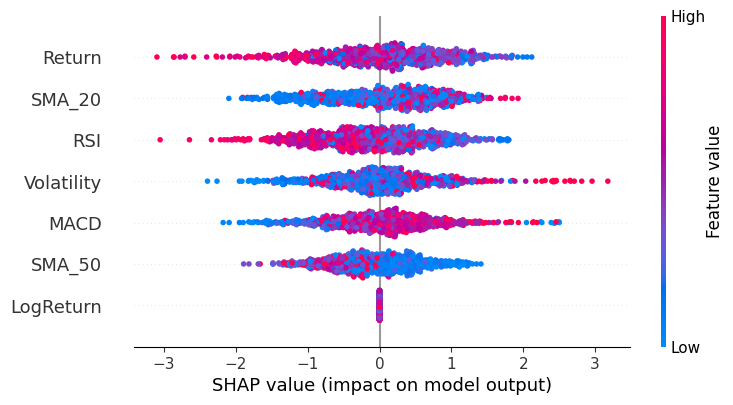

In [73]:
import shap

# Train XGBoost again with new feature set
model = XGBClassifier()
model.fit(X, y)

# SHAP explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Beeswarm plot (global feature importance)
shap.plots.beeswarm(shap_values)


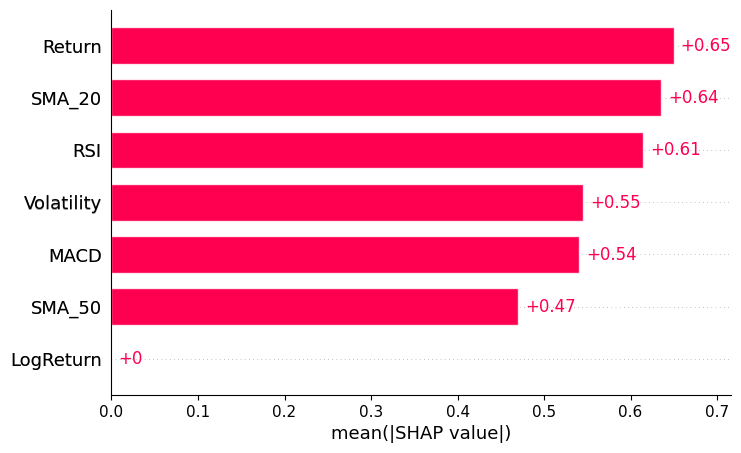

In [74]:
shap.plots.bar(shap_values)

## Baseline Comparison: Random Strategy

In [81]:
# ---- Add Random Strategy as Baseline ----

# Create random predictions (0 or 1) of same length as y_test
random_pred = np.random.randint(0, 2, size=len(y_test))

# Use same df slice as other models
temp = df.iloc[len(df) - len(y_test):].copy()
temp['pred'] = random_pred
temp['return'] = temp['Close'].pct_change().shift(-1)
temp['strategy_return'] = temp['pred'] * temp['return']

# Sharpe Ratio for random predictions
sharpe_random = temp['strategy_return'].mean() / temp['strategy_return'].std() * np.sqrt(252)

# Add to results
results['Random Baseline'] = {'Accuracy': 'N/A', 'Sharpe Ratio': round(sharpe_random, 2)}

# Reprint updated results
results_df = pd.DataFrame(results).T
print(results_df)


                    Accuracy Sharpe Ratio
Logistic Regression  0.51515         1.26
Random Forest        0.52525         2.57
XGBoost              0.53535          3.3
Random Baseline          N/A         0.88
